In [1]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import sqlite3
sns.set_style("whitegrid")
import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
from op import FleetSizeOptimizer
os.chdir('../')

In [2]:
fleetsize_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date
        try:
            with open(f'output/demand_variation/fleet_op_result/alpha_0_demand_1500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleetsize_07.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))
        
            # with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
            #     fleet_i = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))

            # if fleet_i == 7:
            #     df  = pd.read_csv(f'input/demand_variation/passenger_arrival/alpha_7_demand_500/{month}_{day}.csv')
            #     df.to_csv(f'for_emin/passenger_arrival_demand_500_{month}_{day}.csv', index=False)
        
        except FileNotFoundError:
            continue

fleetsize_07 = np.array(fleetsize_07)


In [6]:
fleetsize_07

array([12, 14, 13, 13, 13, 12, 13, 13, 12, 13, 13, 12, 14, 12, 13, 12, 12,
       13, 13, 11, 12, 13, 11, 12, 13, 13, 15, 14, 12, 11, 12, 12, 12, 12,
       14, 12, 12, 13, 12, 12, 13, 13, 11, 11, 13, 13, 12, 13, 14, 14, 11,
       13, 12, 12, 12, 13, 13, 12, 13, 12, 12, 13, 13, 12, 12, 14, 12, 12,
       14, 13, 15, 14, 15, 13, 14, 12, 13, 13, 13, 12, 15, 12, 13, 13, 13,
       13, 14, 12, 14, 14, 12, 12, 14, 15, 13, 12, 13, 13, 13, 12, 13, 13,
       13, 14, 13, 13, 12, 13, 15, 12, 13, 14, 12, 13, 13, 13, 14, 13, 13,
       12, 14, 12, 14, 12, 13, 12, 13, 14, 14, 12, 11, 13, 12, 13, 13, 15,
       14, 15, 14, 13, 13, 13, 14, 12, 12, 14, 16, 12, 11, 14, 12, 12, 12,
       13, 12, 13, 13, 12, 12, 16, 14, 13, 13, 13, 12, 14, 14, 13, 13, 13,
       13, 13, 13, 14, 13, 13, 12, 13, 16, 13, 13, 13, 12, 13, 12, 13, 13,
       14, 14, 13, 14, 14, 13, 13, 14, 14, 13, 14, 12, 14, 13, 13, 15, 13,
       14, 15, 14, 14, 14, 13, 13, 14, 15, 14, 13, 14, 14, 15, 15, 14, 12,
       13, 13, 13, 14, 12

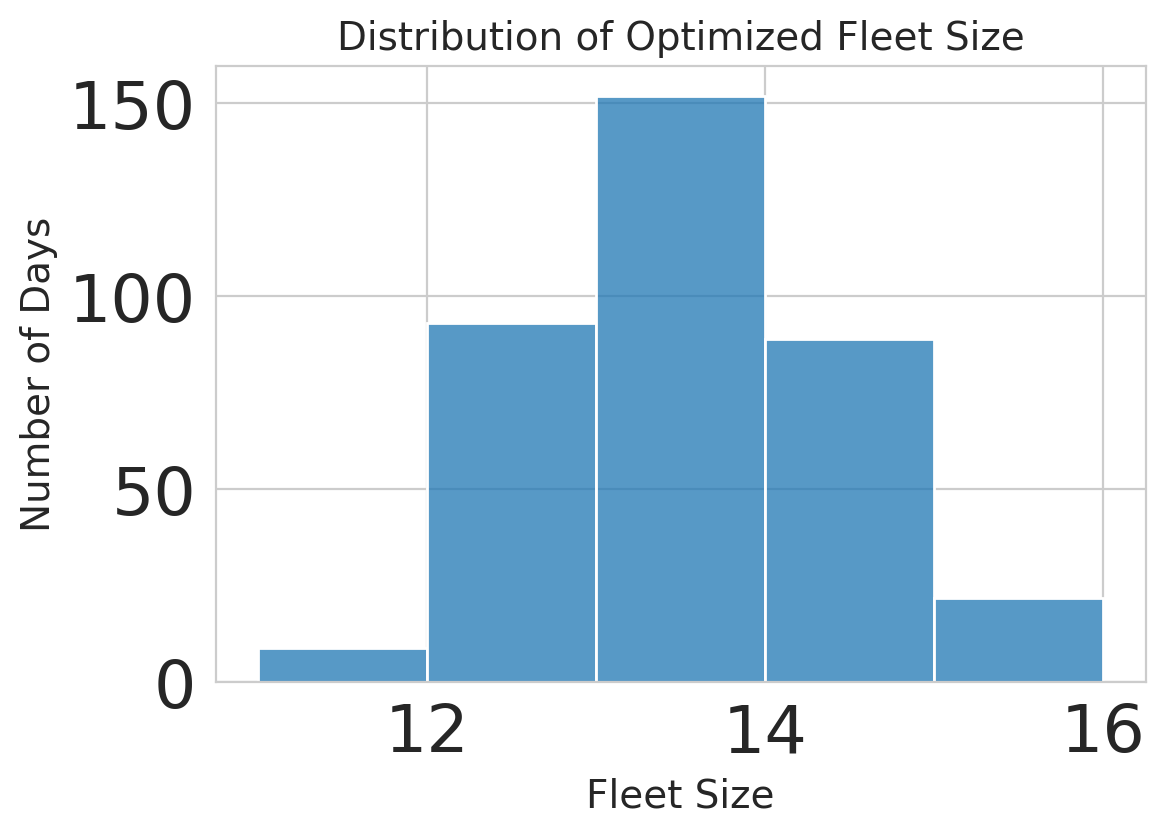

In [5]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.histplot(fleetsize_07, binwidth=1, ax=ax)
ax.set(xlabel='Fleet Size', ylabel='Number of Days', title='Distribution of Optimized Fleet Size');

In [4]:
file_list = os.listdir('output/demand_variation/fleet_op_result/alpha_7_demand_500')
all_files = []
for filename in file_list:
    if filename.endswith('_op_result.txt'):
        all_files.append(filename)


conn = sqlite3.connect('result_alpha_7_pax_500.sqlite')
for i in range(len(all_files)):
    # Load parameters
    run_id = all_files[i].split('_op_result.txt')[0]

    flight_time = np.array([[0, 10],[10, 0]]).astype(int)
    energy_consumption = np.array([[0, 10],[10, 0]]).astype(int)
    flight_distance = np.array([[0, 10],[10, 0]]).astype(int)

    # Call optimizer class and redner summary
    optimizer = FleetSizeOptimizer(flight_time, energy_consumption, schedule=f'demand_variation/schedule/alpha_7_demand_500/{run_id}.csv')
    result_path = f'demand_variation/fleet_op_result/alpha_7_demand_500/{run_id}_op_result.txt'
    optimizer.parse_result(result_path)
    optimizer.calculate_aircraft_states()
    summary = optimizer.get_summary_statistics(flight_distance, return_summary=True)

    # Save summary statistics
    line_i = np.array([summary['fleet_size'], summary['pads'][0], summary['pads'][1], summary['number_of_repositioning_flights']])
    summary_statistics = pd.DataFrame(line_i.reshape(1,4), columns=['fleet_size', 'pads_at_SFO', 'pads_at_SJC', 'number_of_repositioning_flights'])
    summary_statistics['id'] = run_id
    summary_statistics.to_sql('op_summary_statistics', conn, if_exists='append', index=False)

    # Save vertisim inputs
    vertisim_input = pd.concat([optimizer.specificc, optimizer.specificn, optimizer.specificu])
    vertisim_input.reset_index(drop=True, inplace=True)
    vertisim_input['id'] = run_id
    vertisim_input.to_sql('vertisim_input', conn, if_exists='append', index=False)



Fleet size: 7.0
Total number of pads: 11; [4 7] 
Total number of flights: 412.0; demand: 335.0; repositioning: 77.0
Total energy consumption: 1648.0 kWh
Total aircraft miles: 4120.0 mi
Total revenue aircraft miles: 3350.0
Ratio of revenue aircraft miles to aircraft miles: 0.8131067961165048
Fleet size: 6.0
Total number of pads: 9; [4 5] 
Total number of flights: 402.0; demand: 337.0; repositioning: 65.0
Total energy consumption: 1608.0 kWh
Total aircraft miles: 4020.0 mi
Total revenue aircraft miles: 3370.0
Ratio of revenue aircraft miles to aircraft miles: 0.8383084577114428
Fleet size: 7.0
Total number of pads: 12; [6 6] 
Total number of flights: 482.0; demand: 365.0; repositioning: 117.0
Total energy consumption: 1928.0 kWh
Total aircraft miles: 4820.0 mi
Total revenue aircraft miles: 3650.0
Ratio of revenue aircraft miles to aircraft miles: 0.7572614107883817
Fleet size: 7.0
Total number of pads: 12; [5 7] 
Total number of flights: 420.0; demand: 352.0; repositioning: 68.0
Total en

In [5]:

conn = sqlite3.connect('result_alpha_7_pax_500.sqlite')
query = """
SELECT *
FROM op_summary_statistics
"""
df = pd.read_sql_query(query, conn)
df



# Start here

In [1]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import sqlite3
import matplotlib
from op import FleetSizeOptimizer
import warnings
from matplotlib.ticker import MultipleLocator

os.chdir('../')

In [518]:
warnings.filterwarnings('ignore')
plt.style.use("seaborn-white")
sns.set_style('ticks')
color_platte = ['#93003a', '#00429d', '#93c4d2', '#6ebf7c']
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.grid'] = False

### Passenger Demand Number

In [210]:
files = os.listdir('input/demand_variation/passenger_arrival/alpha_7_demand_1500/')
num_pax_1500 = []
for i in files:
    df = pd.read_csv('input/demand_variation/passenger_arrival/alpha_7_demand_1500/'+i).shape[0]
    num_pax_1500.append(df)

files = os.listdir('input/demand_variation/passenger_arrival/alpha_7_demand_2500/')
num_pax_2500 = []
for i in files:
    df = pd.read_csv('input/demand_variation/passenger_arrival/alpha_7_demand_2500/'+i).shape[0]
    num_pax_2500.append(df)

files = os.listdir('input/demand_variation/passenger_arrival/alpha_7_demand_500/')
num_pax_500 = []
for i in files:
    df = pd.read_csv('input/demand_variation/passenger_arrival/alpha_7_demand_500/'+i).shape[0]
    num_pax_500.append(df)

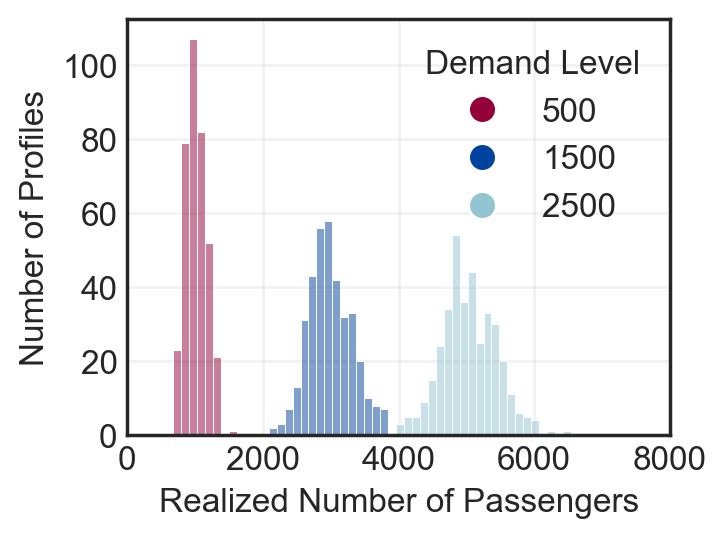

In [233]:
pax_distribution = pd.DataFrame({'pax_num':num_pax_500+num_pax_1500+num_pax_2500, 
                                 'demand_level':np.concatenate([np.repeat(500, len(num_pax_500)),
                                                                np.repeat(1500, len(num_pax_1500)), 
                                                                np.repeat(2500, len(num_pax_2500))])})
fig, ax = plt.subplots(figsize=(3.5,2.7), dpi=200)
sns.histplot(data=pax_distribution, x='pax_num', hue='demand_level', palette=color_platte, ax=ax, bins=50)
ax.set(xlabel='Realized Number of Passengers', ylabel='Number of Profiles', xlim=(0, 8000))

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_platte[i], markersize=10) for i in range(3)]
labels = ['500', '1500', '2500']
ax.legend(handles, labels, title='Demand Level', loc='upper right')
plt.grid(True, alpha=0.25);

## Fleet Size Distribution

In [484]:
def get_fleet_size(demand, alpha=7):
    fleetsize = []
    for month in range(1, 13):
        for day in range(1, 32):
            if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
                continue  # Skip invalid date
            try:
                with open(f'output/demand_variation/fleet_op_result/alpha_{alpha}_demand_{demand}/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                    fleetsize.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))
            except FileNotFoundError:
                continue
    return fleetsize

In [485]:
fleetsize_500 = get_fleet_size(500)
fleetsize_1500 = get_fleet_size(1500)
fleetsize_2500 = get_fleet_size(2500)
fleetsize_1500_0 = get_fleet_size(1500, alpha=0)

In [491]:
np.concatenate([np.repeat(1500, len(fleetsize_500)), np.repeat(1500, len(fleetsize_1500)), np.repeat(2500, len(fleetsize_2500)), np.repeat(1500, len(fleetsize_1500_0))])

array([1500, 1500, 1500, ..., 1500, 1500, 1500])

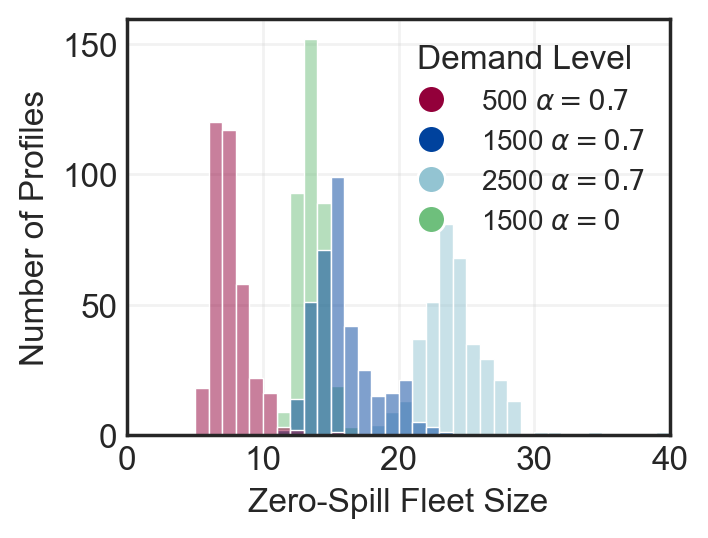

In [545]:
fleetsize_df = pd.DataFrame({'fleetsize':fleetsize_500+fleetsize_1500+fleetsize_2500+fleetsize_1500_0, 'demand_level':np.concatenate([np.repeat(500, len(fleetsize_500)), np.repeat(1500, len(fleetsize_1500)), np.repeat(2500, len(fleetsize_2500)), np.repeat(15000, len(fleetsize_1500_0))])}) 
fig, ax = plt.subplots(figsize=(3.5,2.7), dpi=200)
sns.histplot(data=fleetsize_df, x='fleetsize', hue='demand_level', palette=color_platte, ax=ax, bins=100, binwidth=1)
ax.set(xlim=(0, 40), xlabel='Zero-Spill Fleet Size', ylabel='Number of Profiles')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_platte[i], markersize=10) for i in range(4)]
labels = [r"500 $\alpha=0.7$", r'1500 $\alpha=0.7$', r'2500 $\alpha=0.7$', r"1500 $\alpha=0$"]
ax.legend(handles, labels, title='Demand Level', loc='upper right', fontsize=10)
plt.grid(True, alpha=0.25);

## Spill Distribution

In [459]:
def get_spill(demand, alpha=7):
    spill_list = []
    fleetsize_list = []

    files = os.listdir(f'output/demand_variation/spill_op_result/alpha_{alpha}_demand_{demand}')
    all_files = [file for file in files if file.endswith('_total_spill.txt')]
    file_names = np.empty(shape=(0, 3))
    for i in all_files:
        file_names = np.vstack((file_names, np.array(i.split('_')[:3])))

    # 8-15  for 500
    # 15-25 for 1500
    # 25(27)-40 for 2500

    for i in range(file_names.shape[0]):
        with open(f'output/demand_variation/spill_op_result/alpha_{alpha}_demand_{demand}/'+all_files[i], 'r') as f:
            spill = float(f.readline().split(': ')[1])
        spill_list.append(spill)
        fleetsize_list.append(int(file_names[i,2]))

    return pd.DataFrame({'fleetsize':fleetsize_list, 'spill':spill_list, 'demand_level':np.repeat(demand, len(spill_list))})

In [549]:
spill_500 = get_spill(500)
spill_1500 = get_spill(1500)
spill_2500 = get_spill(2500)
spill_1500_0 = get_spill(1500, alpha=0)

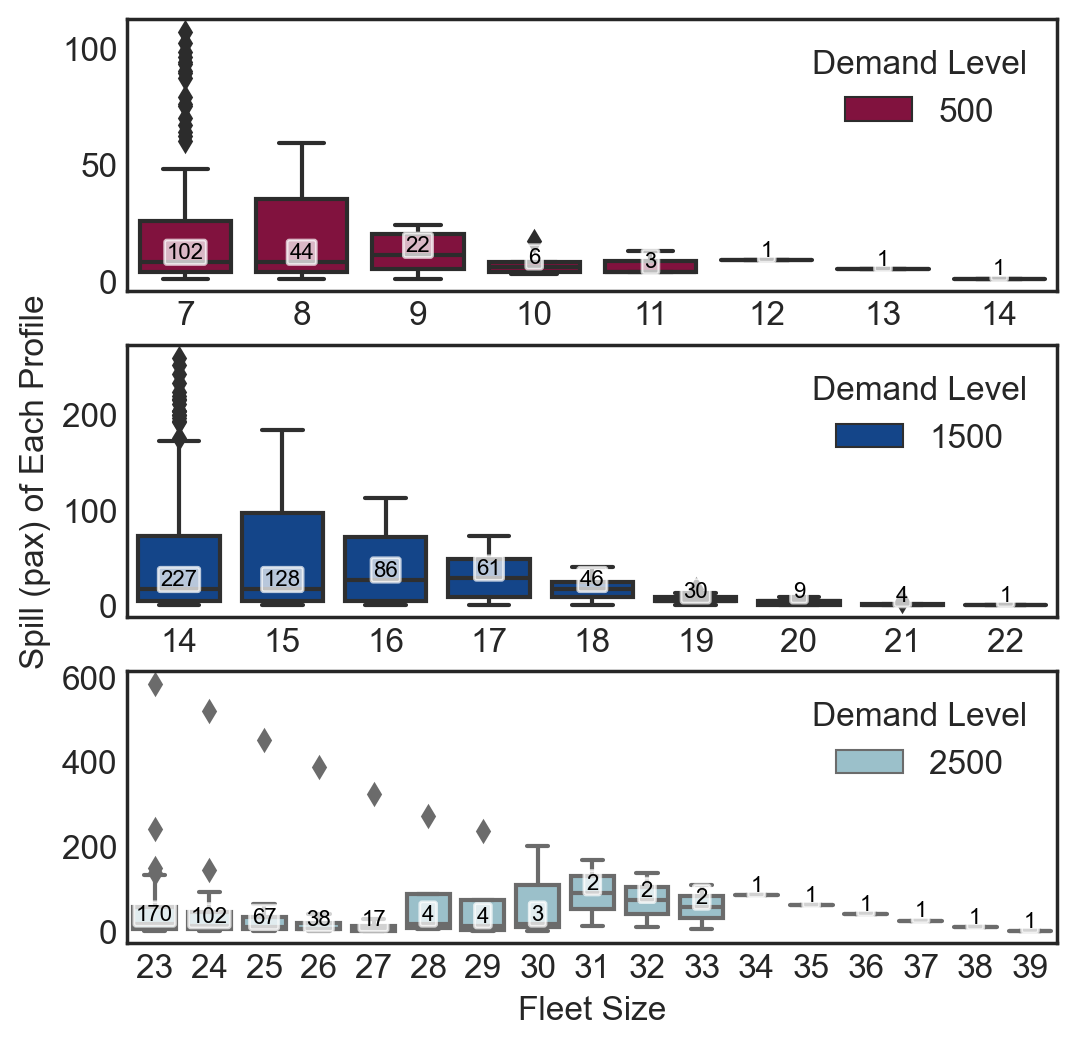

In [574]:
median = spill_500[spill_500['fleetsize'] >6].groupby(['fleetsize', 'demand_level']).median().reset_index()
count = spill_500[spill_500['fleetsize'] >6].groupby(['fleetsize', 'demand_level']).count().reset_index()

fig, ax = plt.subplots(nrows=3, figsize=(6, 6), dpi=200)
sns.boxplot(data=spill_500[spill_500['fleetsize'] >6], x='fleetsize', y='spill', hue='demand_level', width=0.8, ax=ax[0], palette=color_platte)
ax[0].set(ylabel='')

for index, row in median.iterrows():
    x_coord = row['fleetsize'] - 7
    y_coord = row['spill']
    count_val = count[(count['fleetsize'] == row['fleetsize']) & (count['demand_level'] == row['demand_level'])]['spill'].values[0]
    ax[0].text(x_coord, y_coord, str(count_val), color='black', ha='center', va='bottom', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round', pad=0.1))
ax[0].legend(title='Demand Level', loc='upper right')


median = spill_1500[spill_1500['fleetsize'] >13].groupby(['fleetsize', 'demand_level']).median().reset_index()
count = spill_1500[spill_1500['fleetsize'] >13].groupby(['fleetsize', 'demand_level']).count().reset_index()
sns.boxplot(data=spill_1500[spill_1500['fleetsize'] >13], x='fleetsize', y='spill', hue='demand_level', width=0.8, ax=ax[1], palette=color_platte[1:])
ax[1].set(ylabel='Spill (pax) of Each Profile')

for index, row in median.iterrows():
    x_coord = row['fleetsize'] - 14
    y_coord = row['spill']
    count_val = count[(count['fleetsize'] == row['fleetsize']) & (count['demand_level'] == row['demand_level'])]['spill'].values[0]
    ax[1].text(x_coord, y_coord, str(count_val), color='black', ha='center', va='bottom', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round', pad=0.1))

ax[1].legend(title='Demand Level', loc='upper right')


median = spill_2500[spill_2500['fleetsize'] >17].groupby(['fleetsize', 'demand_level']).median().reset_index()
count = spill_2500[spill_2500['fleetsize'] >17].groupby(['fleetsize', 'demand_level']).count().reset_index()

sns.boxplot(data=spill_2500[spill_2500['fleetsize'] >17], x='fleetsize', y='spill', hue='demand_level', width=0.8, ax=ax[2], palette=color_platte[2:])
ax[2].set(xlabel='Fleet Size', ylabel='')

for index, row in median.iterrows():
    x_coord = row['fleetsize'] - 23
    y_coord = row['spill']
    count_val = count[(count['fleetsize'] == row['fleetsize']) & (count['demand_level'] == row['demand_level'])]['spill'].values[0]
    ax[2].text(x_coord, y_coord, str(count_val), color='black', ha='center', va='bottom', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round', pad=0.1))

ax[2].legend(title='Demand Level', loc='upper right')


# Temporal Distribution of Spill

In [474]:
files = os.listdir(f'output/demand_variation/spill_op_result/alpha_7_demand_{1500}')
all_files = [file for file in files if file.endswith('_spill_op_result.txt')]
all_spill = pd.DataFrame(columns=['time', 'o', 'd', 'val', 'fs'])
for i in all_files:
    spill_op_result = pd.read_table('output/demand_variation/spill_op_result/alpha_7_demand_1500/'+i, header=None)
    pattern = r's\[(\d+),(\d+),(\d+)\] = (\d+\.\d+)'
    spill = spill_op_result[0].str.extract(pattern)
    spill = spill[spill[0].isna() == False].reset_index(drop=True)
    spill['fs'] = int(i.split('_')[2])
    spill.columns = ['time', 'o', 'd', 'val', 'fs']
    all_spill = pd.concat([all_spill, spill], axis=0)
all_spill['time'] = all_spill['time'].astype(int)
all_spill['val'] = all_spill['val'].astype(float)

In [479]:
all_spill = all_spill[all_spill['fs'] >= 14]
all_spill_grouped = all_spill.groupby(['time', 'fs'])['val'].mean().reset_index()
all_spill_grouped = all_spill_grouped[all_spill_grouped['fs'] <= 20]

empty = pd.DataFrame({'time':np.tile(np.arange(1, 290), 7), 'fs':np.repeat(np.arange(14, 21), 289)})
all_spill_grouped = pd.merge(all_spill_grouped, empty, on=['time', 'fs'], how='right')
all_spill_grouped.fillna(0, inplace=True)
all_spill_grouped = all_spill_grouped.pivot(index='fs', columns='time', values='val')

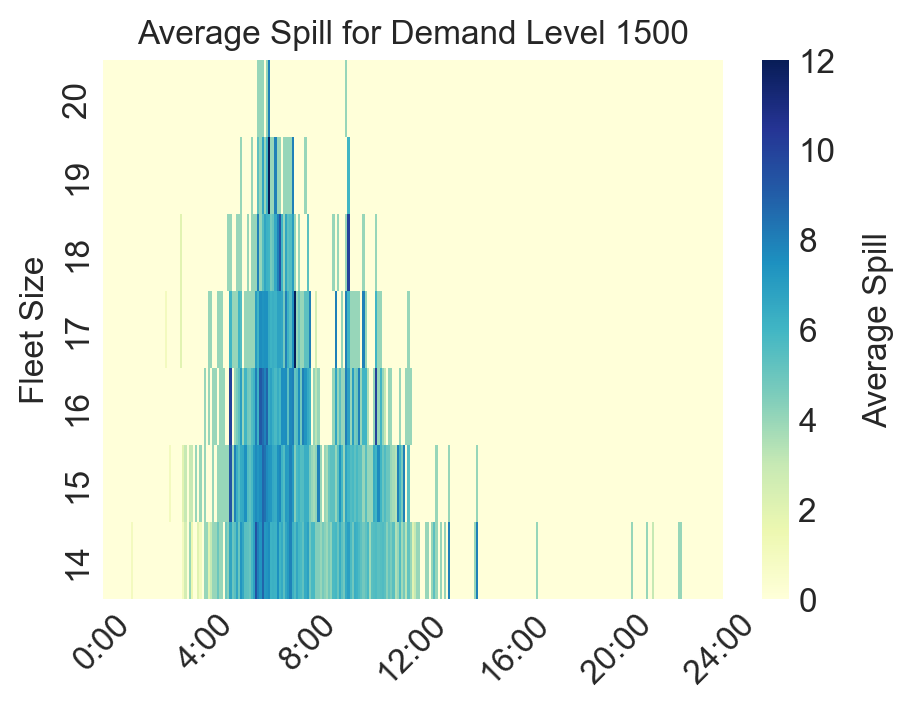

In [480]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(5,3.5), dpi=200)
sns.heatmap(all_spill_grouped, cmap='YlGnBu', ax=ax)
ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.set(xlabel='', ylabel='Fleet Size', title='Average Spill for Demand Level 1500', xticks=np.arange(0, 288+24, 48), xticklabels=[str(i*4)+':00' for i in range(0, 7)])
plt.gca().invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.set_label('Average Spill', labelpad=10)

## Compare to the queueing system

In [238]:
from tqdm import tqdm
import importlib
import model.queueing_model
importlib.reload(model.queueing_model)
from model.queueing_model import *

In [375]:
def upper_lower_bound(demand, input_range):

    upper_bound = np.zeros(input_range[1]-input_range[0])
    lower_bound = np.zeros(input_range[1]-input_range[0])

    for month in tqdm(range(1, 13)):
        for day in range(1, 32):
            if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
                continue  # Skip invalid dates
            else:
                try:
                    with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_{demand}/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                        fleetsize = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))
                

                    for i in range(input_range[0], input_range[1]):
                        if fleetsize > i:
                            s = system(i, f'input/demand_variation/schedule/alpha_7_demand_{demand}/num_pax_{month}_{day}.csv', 
                                        f'input/demand_variation/schedule/alpha_7_demand_{demand}/{month}_{day}.csv')
                            upper_bound[i-input_range[0]] += s.logger(True)

                            s2 = one_vertiport_system(i, f'input/demand_variation/schedule/alpha_7_demand_{demand}/num_pax_{month}_{day}.csv', 
                                                        f'input/demand_variation/schedule/alpha_7_demand_{demand}/{month}_{day}.csv')
                            lower_bound[i-input_range[0]] += s2.logger(True)
                except FileNotFoundError:
                    continue
    return upper_bound, lower_bound    

In [376]:
# ub_2500, lb_2500 = upper_lower_bound(2500, [20,40])
# ub_1500, lb_1500 = upper_lower_bound(1500, [10,25])
ub_500, lb_500 = upper_lower_bound(500, [5,15])

100%|██████████| 12/12 [01:47<00:00,  8.98s/it]


In [377]:
data_to_pickle = (ub_500, lb_500)
with open('DemandUncertainty/ub_lb_500.pkl', 'wb') as f:
    pickle.dump(data_to_pickle, f)

In [563]:
spill_500.groupby('fleetsize').sum()['spill']

fleetsize
7     2340.0
8      876.0
9      269.0
10      44.0
11      21.0
12       9.0
13       5.0
14       1.0
Name: spill, dtype: float64

In [570]:
y_spill_500 = spill_500.groupby('fleetsize').sum()['spill']
y_spill_1500 = spill_1500.groupby('fleetsize').sum()['spill'][4:-1]
y_spill_2500 = spill_2500.groupby('fleetsize').sum()['spill'][1:]
y_spill_1500_alpha_0 = spill_1500_0.groupby('fleetsize').sum()['spill']

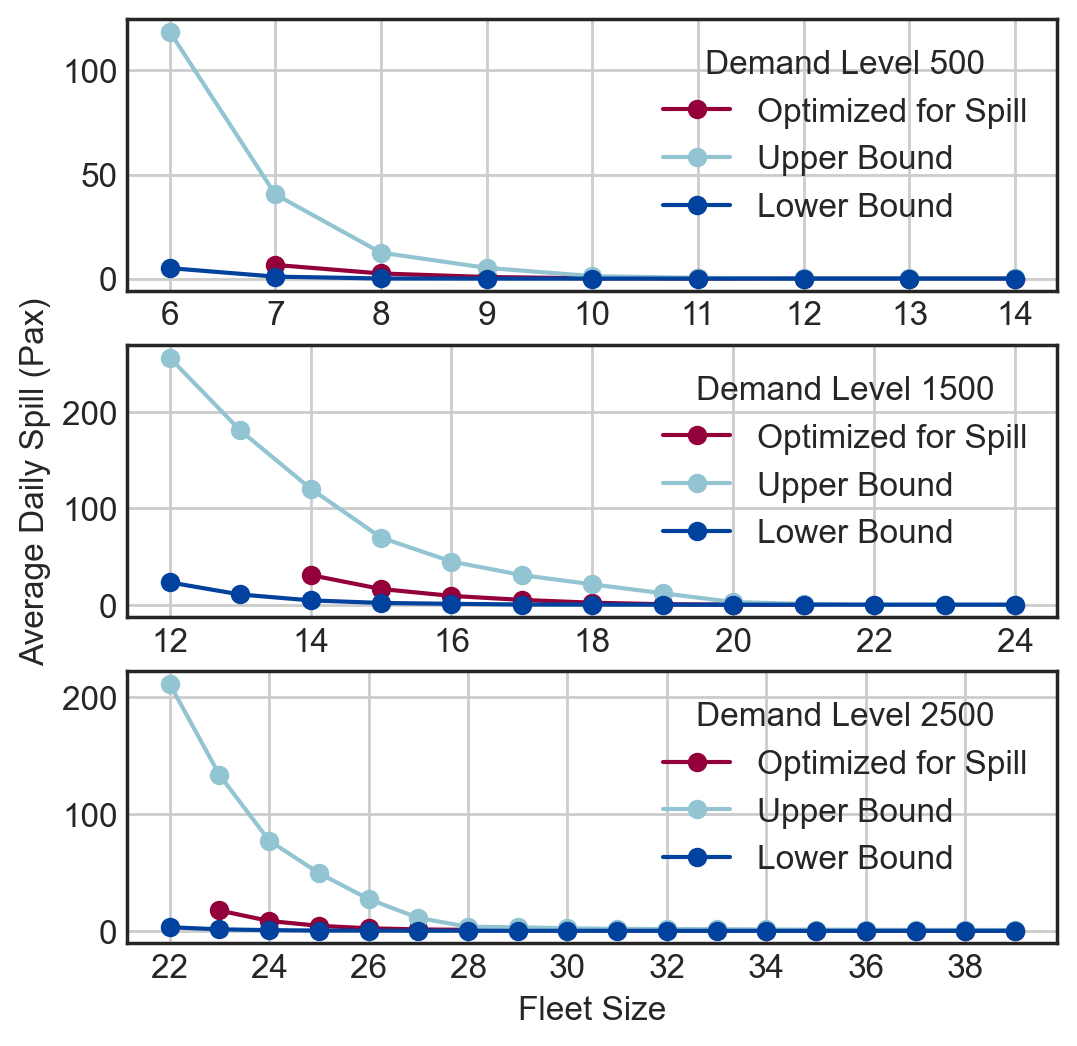

In [573]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(dpi=200, nrows=3, figsize=(6,6))

# 500 Pax
ax[0].plot(np.arange(7, 15), y_spill_500/357, marker='o', color=color_platte[0],
       label='Optimized for Spill')
ax[0].plot(np.arange(6, 15), ub_500[1:]/357, marker='o', color=color_platte[2], 
       label='Upper Bound')
ax[0].plot(np.arange(6, 15), lb_500[1:]/357, marker='o', color=color_platte[1], 
       label='Lower Bound')
ax[0].legend(title='Demand Level 500')

# 1500 Pax
ax[1].plot(np.arange(14, 22), y_spill_1500/365, marker='o', color=color_platte[0],
       label='Optimized for Spill')
ax[1].plot(np.arange(12, 25), ub_1500[2:]/365, marker='o', color=color_platte[2], 
       label='Upper Bound')
ax[1].plot(np.arange(12, 25), lb_1500[2:]/365, marker='o', color=color_platte[1], 
       label='Lower Bound')
ax[1].set(ylabel='Average Daily Spill (Pax)')
ax[1].legend(title='Demand Level 1500')

# 2500 Pax
ax[2].plot(np.arange(23, 40), y_spill_2500/365, marker='o', color=color_platte[0],
       label='Optimized for Spill')
ax[2].plot(np.arange(22, 40), ub_2500[2:]/365, marker='o', color=color_platte[2], 
       label='Upper Bound')
ax[2].plot(np.arange(22, 40), lb_2500[2:]/365, marker='o', color=color_platte[1], 
       label='Lower Bound')
ax[2].legend(title='Demand Level 2500')
ax[2].set(xticks=np.arange(22, 40, 2), xlabel='Fleet Size')

for i in range(3):
       ax[i].grid()

In [473]:
y_spill_1500_alpha_0.to_numpy()


array([575.,  99.,  12.])

<Axes: xlabel='fleetsize'>

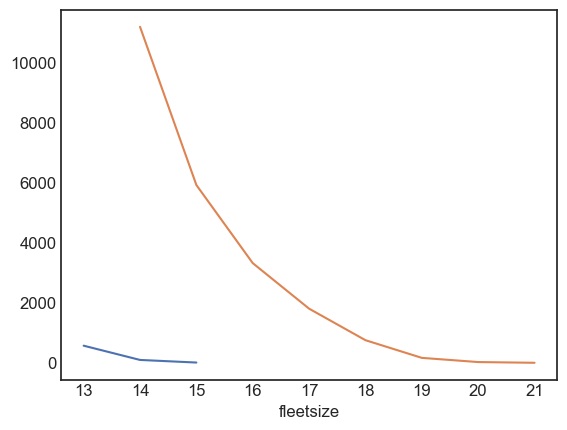

In [566]:
y_spill_1500_alpha_0.plot()
y_spill_1500.plot()

# Example Demand Profile

In [2]:
from UAM_Schedule import UAM_Schedule
from tqdm import tqdm
plt.rcParams['font.size'] = 16
u = UAM_Schedule('DemandUncertainty/LAX_ind.csv', 'DemandUncertainty/T_F41SCHEDULE_B43.csv')

In [40]:
def get_realized_val(UAM_Schedule, day, month, alpha, demand_level):
    one_day, pax_arrival, num_pax = UAM_Schedule.get_one_day(day, month, alpha, demand_level)
    pax_arrival['passenger_arrival_time'] += 0.00001
    pax_arrival['passenger_arrival_time'] = np.ceil(pax_arrival['passenger_arrival_time']/3600).astype(int)
    

    empty_df = pd.DataFrame({'time':np.arange(1, 25, 1), 'num_pax':np.zeros(24)})

    arrival_time_lax = pax_arrival[pax_arrival['origin_vertiport_id'] == 'LAX'].reset_index(drop=True)
    pax_arrive_lax = arrival_time_lax.groupby(['passenger_arrival_time']).count().reset_index()
    pax_arrive_lax = empty_df.merge(pax_arrive_lax, how='left', left_on='time', right_on='passenger_arrival_time')
    pax_arrive_lax.fillna(0, inplace=True)
    realized_lax_dtla = pax_arrive_lax['passenger_id'].values

    arrival_time_dtla = pax_arrival[pax_arrival['origin_vertiport_id'] == 'DTLA'].reset_index(drop=True)
    pax_arrive_dtla = arrival_time_dtla.groupby(['passenger_arrival_time']).count().reset_index()
    pax_arrive_dtla = empty_df.merge(pax_arrive_dtla, how='left', left_on='time', right_on='passenger_arrival_time')
    pax_arrive_dtla.fillna(0, inplace=True)
    realized_dtla_lax = pax_arrive_dtla['passenger_id'].values

    return realized_lax_dtla, realized_dtla_lax


100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Text(0.5, 0.01, 'Time of Day')

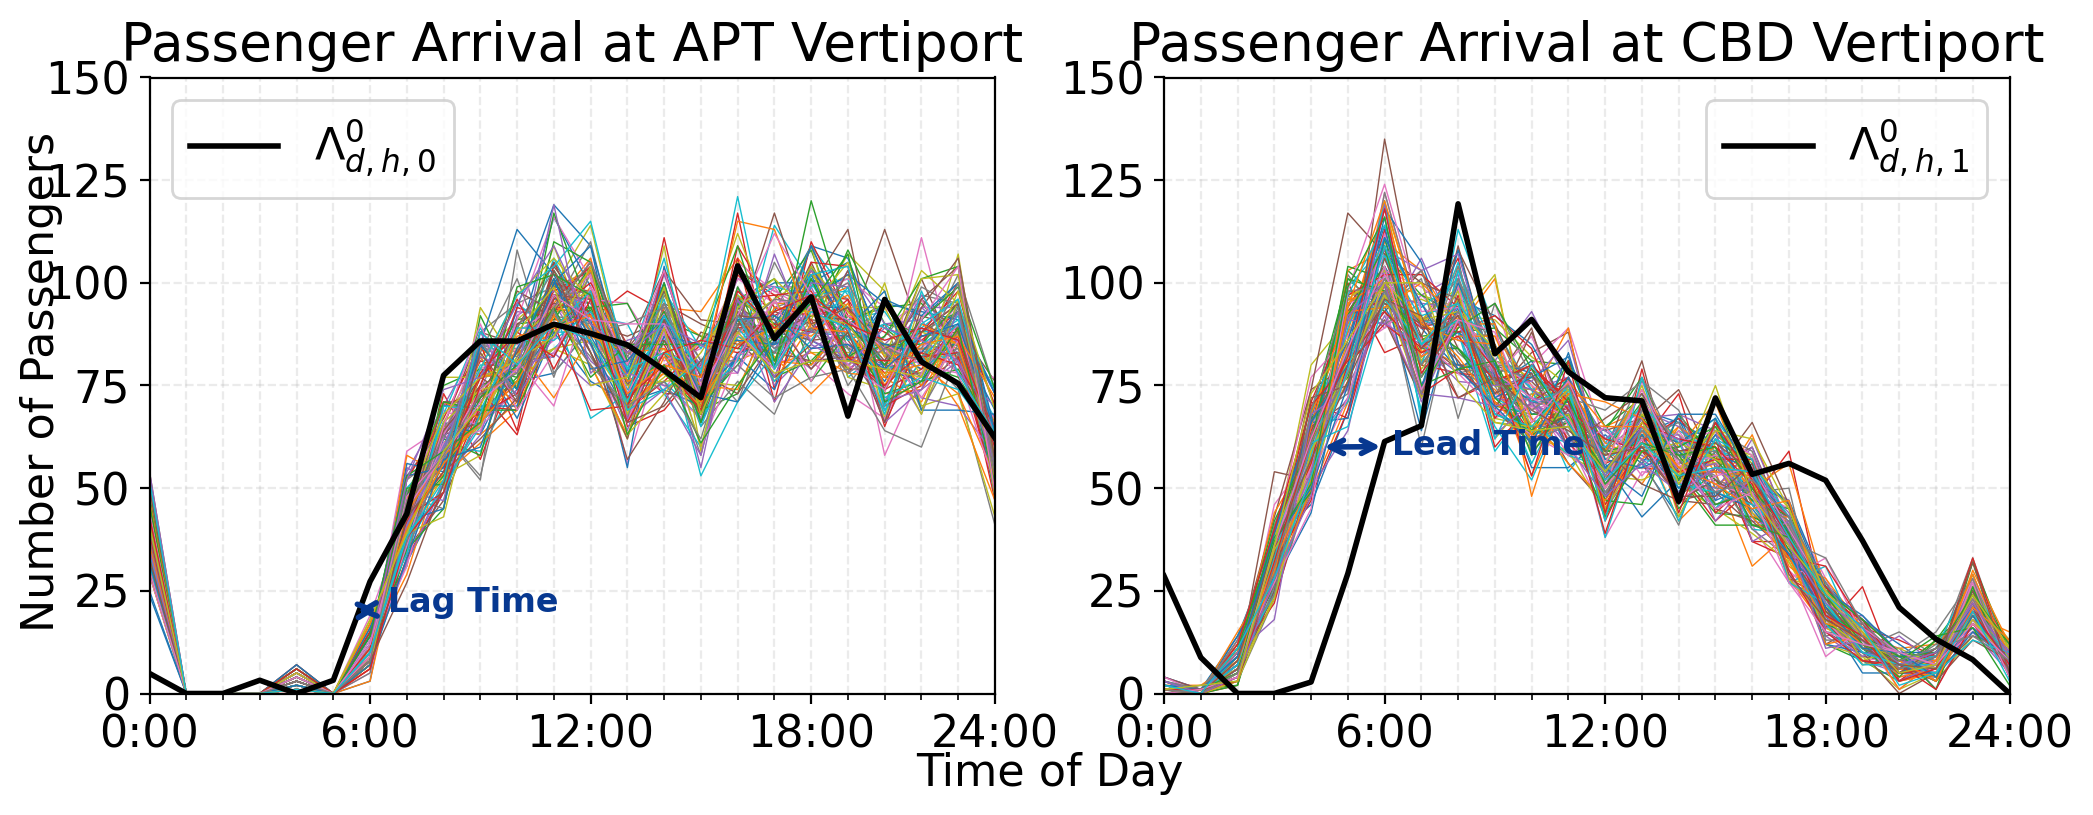

In [105]:
minorLocator = MultipleLocator(1)

fig, ax = plt.subplots(dpi=200, figsize=(12,4), ncols=2)
for i in tqdm(range(100)):
    realized_lax_dtla, realized_dtla_lax = get_realized_val(u, 1, 1, 0, 1500)
    sns.lineplot(y=realized_lax_dtla, x=np.arange(24), linewidth=0.5, ax=ax[0])
    sns.lineplot(y=realized_dtla_lax, x=np.arange(24), linewidth=0.5, ax=ax[1])

sns.lineplot(y=lax_flight_arr_rate, x=np.arange(24), linewidth=2, ax=ax[0], color='black', label='$\Lambda_{d,h,0}^{0}$')
sns.lineplot(y=lax_flight_dep_rate, x=np.arange(24), linewidth=2, ax=ax[1], color='black', label='$\Lambda_{d,h,1}^{0}$')

for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
                xticks=[0,6,12,18,24-1], xticklabels=['0:00', '6:00', '12:00', '18:00', '24:00'],
                ylim=(0,150),
                xlim=(0,23));
    ax[i].xaxis.set_minor_locator(minorLocator)
    ax[i].grid(True, alpha=0.25, linestyle='--', which='both')
ax[0].set(title='Passenger Arrival at APT Vertiport')
ax[1].set(title='Passenger Arrival at CBD Vertiport')
ax[0].annotate('Lag Time', xy=(5.5, 20), xytext=(6.5, 20), size=12, fontweight='bold', color='#073890',
                arrowprops=dict(arrowstyle='<->', color='#073890', lw=2))
ax[1].annotate('Lead Time', xy=(4.2, 60), xytext=(6.2, 58), size=12, fontweight='bold', color='#073890',
                arrowprops=dict(arrowstyle='<->', color='#073890', lw=2))

fig.text(0.08, 0.5, 'Number of Passengers', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time of Day', ha='center', va='center')

In [76]:



fig, ax = plt.subplots(ncols=2, nrows=len(alphas), figsize=(10,16),dpi=300)

    for i in range(100):
        realized_lax_dtla = pois_generate(lax_dtla_rate, alpha=alpha)
        realized_dtla_lax = pois_generate(dtla_lax_rate, alpha=alpha)

        sns.lineplot(y=realized_lax_dtla, x=np.arange(24), ax=ax[idx, 0], linewidth=0.5)
        sns.lineplot(y=realized_dtla_lax, x=np.arange(24), ax=ax[idx, 1], linewidth=0.5)

    for i in range(2):
        ax[idx, i].set(xlabel='', ylabel='', 
                    xticks=[0,6,12,18,24], xticklabels=['0:00', '6:00', '12:00', '18:00', '24:00'],
                    ylim=(0,200),
                    xlim=(0,24))
        
        ax[idx, i].text(1.5, 150, r"$\alpha=$"+str(round(alpha,2)))
        ax[idx, i].grid(True)
        
        if i == 0:
            sns.lineplot(y=lax_dtla_rate, x=np.arange(24), ax=ax[idx, i], label='$\lambda$', linewidth=2, color='black')
        elif i == 1:
            sns.lineplot(y=dtla_lax_rate, x=np.arange(24), ax=ax[idx, i], label='$\lambda$', linewidth=2, color='black')

    ax[0,0].set_title('LAX_DTLA with AutoRegP')
    ax[0,1].set_title('DTLA_LAX with AutoRegP')

array([24, 12,  4,  8, 10, 17, 22, 40, 39, 38, 52, 49, 57, 62, 42, 61, 41,
       53, 54, 49, 40, 39, 41, 69, 49, 46, 44, 47, 41, 36, 28, 39, 43, 32,
       33, 37, 20, 18])

## Get a new demand profile

In [4]:
from UAM_Schedule import UAM_Schedule

In [156]:
# sche = UAM_Schedule('DemandUncertainty/LAX_ind.csv', 'DemandUncertainty/T_F41SCHEDULE_B43.csv')
schedule, pax_arrival_times, num_pax = u.get_one_day(1, 1, directional_demand=1500)

In [577]:
schedule = pd.read_csv('input/icrat_wind/demand/schedule_500pax_5min_0206.csv')

In [578]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ="whitegrid", font_scale=1.5)
import numpy as np

lax_dtla_sche = schedule[schedule['od'] == 'LAX_DTLA']
dtla_lax_sche = schedule[schedule['od'] == 'DTLA_LAX']

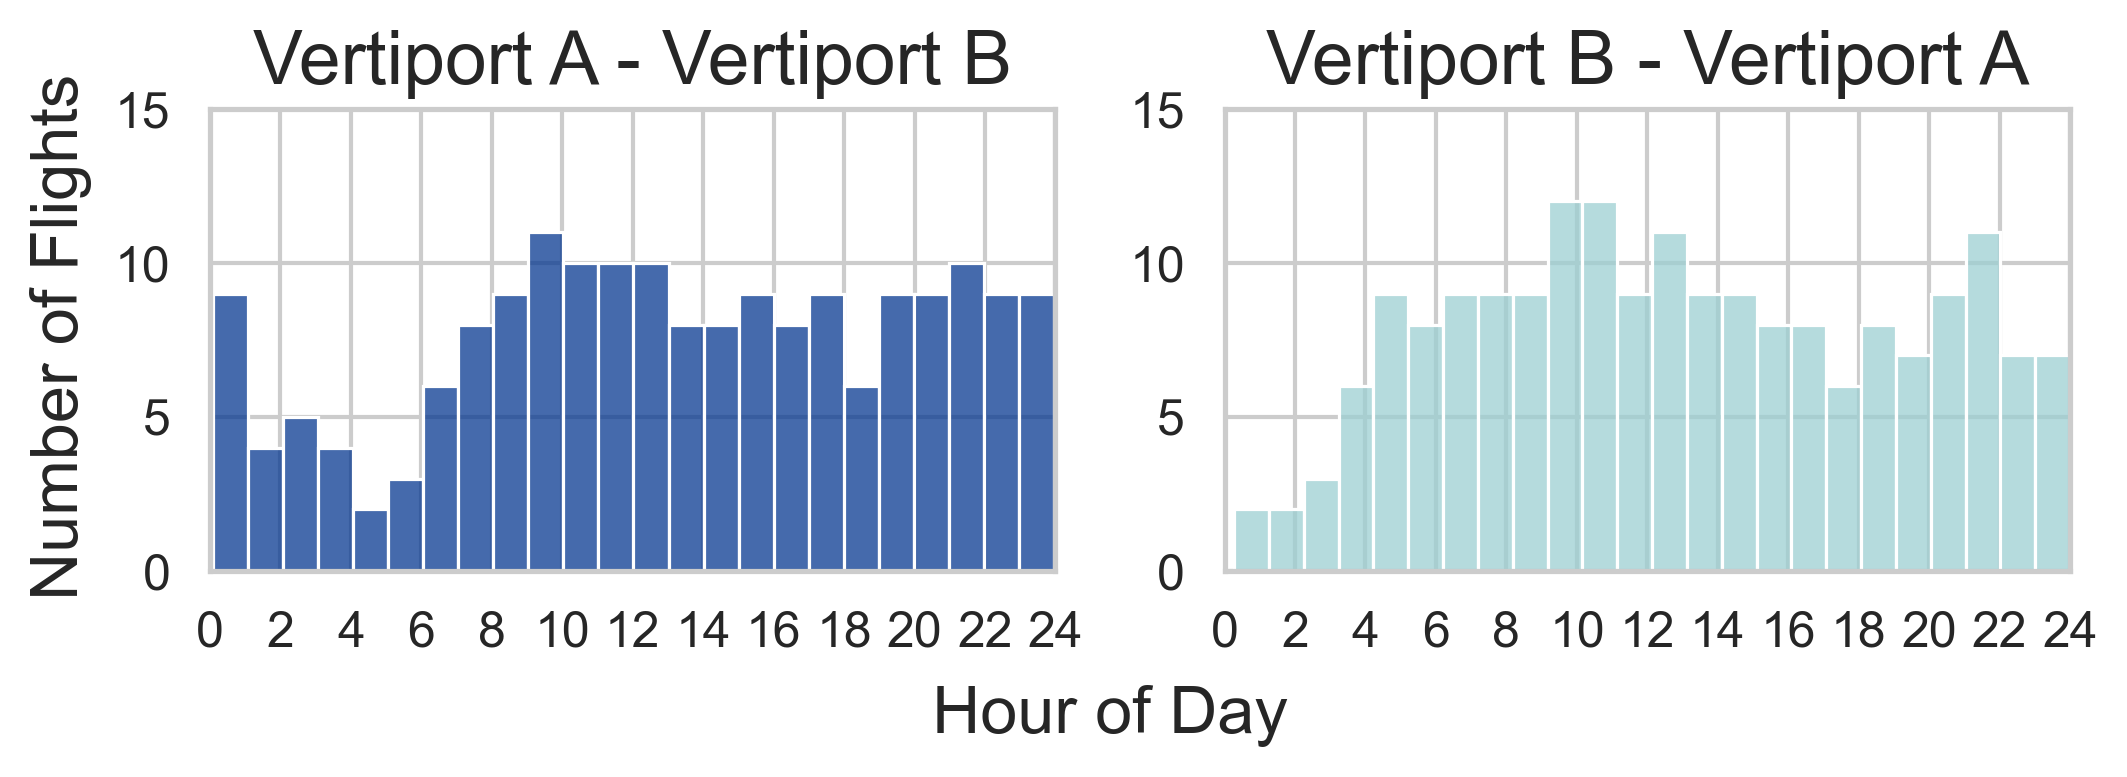

In [582]:
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(dpi=200, ncols=2, figsize=(8,2))
sns.histplot(lax_dtla_sche['schedule'], bins=24, ax=ax[0], color='#073890', label='LAX-DTLA')
sns.histplot(dtla_lax_sche['schedule'], bins=24, ax=ax[1], color='#9ccfd2',label='DTLA-LAX')

for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
              xticks=np.arange(0,1560,120), 
              xticklabels=np.arange(0,26,2),
              yticks=np.arange(0,32,5),
              ylim=(0,15),
              xlim=(0,1440))
    ax[i].tick_params(axis='both', labelsize=12)

ax[0].set(title='Vertiport A - Vertiport B')
ax[1].set(title='Vertiport B - Vertiport A')
fig.text(0.5, -0.16, 'Hour of Day', ha='center', fontsize=16)
# fig.text(0.5, 1, 'Hourly Scheduled Departures at Vertiports \n (5min threshold)', ha='center', fontsize=24)
fig.text(0.05, 0.5, 'Number of Flights', va='center', rotation='vertical', fontsize=16)
plt.gcf().set_dpi(300)

In [9]:
schedule.to_csv('input/icrat_wind/demand/schedule_500pax_5min_0206.csv', index=False)
pax_arrival_times.to_csv('input/icrat_wind/demand/pax_arrival_times_500pax_5min_0206.csv', index=False)
num_pax.to_csv('input/icrat_wind/demand/num_pax_500pax_5min_0206.csv', index=False)